## Introduction

**Задача:**
- Воспроизведите график числа рекламных событий по дням. 
- Найдите причину резкого увеличения количества рекламных событий и объясните, что произошло. 
- Предложите способ, который помог бы автоматически детектировать аномальные изменения метрик на графиках рекламной статистики. Иными словами, предложите алгоритм, который каждое утро анализирует данные за прошедшие сутки, и, если они сильно выбиваются из общего тренда, отправляет аналитику уведомление: на этом графике есть проблема за вчерашний день. Подумайте, как сделать детектор, который проверяет на аномалии каждый час, каждые пять минут в графике? 
Предложите вариант кода, который решает эту задачу. Реализовывать логику нотификации не нужно, только поиск аномального дня, часа, пятиминутки в данных рекламной статистики. 


**Описание данных:**
- **time** — время взаимодействия пользователя с рекламой в формате UnixTime;
- **event** — тип взаимодействия (click — клик на объявление, view — показ объявления, report — жалоба на объявление);
- **ad_cost_type** — тип трат рекламного объявления (CPM — траты за 1000 показов, CPC — траты за клик);
- **has_video** — наличие видео в объявлении (0 — нет, 1 — есть);
- **agency_union_id** — id рекламного агентства (если рекламный кабинет принадлежит физическому лицу, то ячейка будет заполнена значением 'no_agency');
- **client_union_id** — id рекламного клиента;
- **campaign_union_id** — id рекламной кампании;
- **ad_id** — id рекламного объявления;
- **platform** — платформа, с которой пользователь взаимодействовал с рекламой (web — веб-версия, mvk — мобильная - версия, iphone — IOS-приложение, android — Android-приложение, wphone — Windows Phone-приложение).

## Imports

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
plt.xkcd()
%matplotlib inline

## Reading data

In [2]:
data = pd.read_csv('test_data.csv')

print('Shape: ' + str(data.shape))
data.head()

Shape: (122097, 10)


,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date
0,1.554744e+09,report,CPM,0,no_agency,client_21074,campaign_27489,ad_27489,android,2019-04-08
1,1.555103e+09,click,CPM,0,no_agency,client_22392,campaign_35893,ad_35893,android,2019-04-12
2,1.555403e+09,click,CPM,0,no_agency,client_16836,campaign_26799,ad_26804,web,2019-04-16
3,1.554822e+09,click,CPM,0,no_agency,client_22920,campaign_37146,ad_37146,android,2019-04-09
4,1.554967e+09,click,CPM,0,no_agency,client_645,campaign_15893,ad_15944,web,2019-04-11


In [3]:
data.describe()

,time,has_video
count,1.220970e+05,122097.000000
mean,1.554875e+09,0.005471
std,3.691914e+05,0.073764
min,1.554077e+09,0.000000
25%,1.554621e+09,0.000000
50%,1.554979e+09,0.000000
75%,1.555157e+09,0.000000
max,1.555459e+09,1.000000


In [4]:
data.nunique()

time                 113789
event                     3
ad_cost_type              2
has_video                 2
agency_union_id         351
client_union_id        8709
campaign_union_id     12330
ad_id                 18049
platform                  5
date                     16
dtype: int64

In [5]:
# Convert 'time' feature from UNIX type to date
data['time'] = pd.to_datetime(data['time'], unit='s')
data['time'] = data['time'].apply(lambda x: (x.replace(second=0)))

data['hour'] = data['time'].apply(lambda x: x.hour)
data['minute'] = data['time'].apply(lambda x: x.minute)

# From 'date' feature we need only number of the day
data['date'] = data['date'].apply(lambda x: x[-2:]).astype(int)

In [6]:
data.head()

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date,hour,minute
0,2019-04-08 17:22:00,report,CPM,0,no_agency,client_21074,campaign_27489,ad_27489,android,8,17,22
1,2019-04-12 21:10:00,click,CPM,0,no_agency,client_22392,campaign_35893,ad_35893,android,12,21,10
2,2019-04-16 08:16:00,click,CPM,0,no_agency,client_16836,campaign_26799,ad_26804,web,16,8,16
3,2019-04-09 15:07:00,click,CPM,0,no_agency,client_22920,campaign_37146,ad_37146,android,9,15,7
4,2019-04-11 07:11:00,click,CPM,0,no_agency,client_645,campaign_15893,ad_15944,web,11,7,11


## Plots

In [7]:
def plot_features(features):
    """Function that prints feature values per day."""
    
    # Set figure with len(features) subplots
    figure, ax = plt.subplots(len(features) // 2, 2,
                              figsize=(14, 3 * len(features)))
    # Get unique days
    dates = data['date'].sort_values().unique()
    
    # Plot every feature
    for index, feature in enumerate(features):
        # 2D matrix with values of every category of feature
        # distribution in every day of the period
        feature_values = []
        feature_names = list(data.groupby(feature).size().index)

        # Count value for 2D matrix day by day
        for date in dates:
            feature_values.append(
                list(data[data['date'] == date].groupby(feature).size()))

        # Turn matrix to numpy matrix
        feature_values = np.array(feature_values)

        # Plot values of a matrix
        for i in range(len(feature_values[0])):
            ax[index // 2, index % 2].plot(
                dates, feature_values[:, i], label = feature_names[i])

        # Set captures
        ax[index // 2, index % 2].set_title(feature)
        ax[index // 2, index % 2].set_xlabel('Day (of April)')
        ax[index // 2, index % 2].set_ylabel('Number of actions')
        ax[index // 2, index % 2].legend()


def plot_ad_popularity(ads):
    """Function that plots ad shows per day."""
    # Set figure
    plt.figure(figsize=(14, 5))
    # Get unique days
    dates = data['date'].sort_values().unique()
    
    for ad in ads:
        # Array for storing values per day for current ad
        feature_values = []

        # Count value for 2D matrix day by day
        for date in dates:
            temp = data[(data['date'] == date)
                        & (data['ad_id'] == ad)].shape[0]
            feature_values.append(temp)

        # Plot values of an array
        plt.plot(dates, feature_values, label = ad)

        # Set captures
        plt.title('Ad statistics of distribution')
        plt.xlabel('Day (of April)')
        plt.ylabel('Number of actions')
        plt.legend()

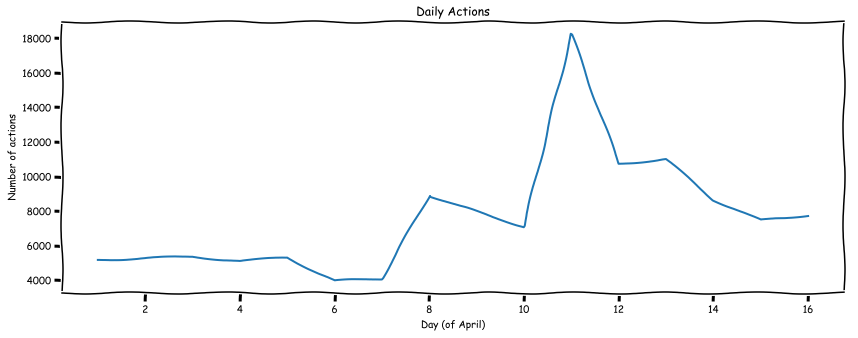

In [8]:
# Set figure size
plt.figure(figsize=(14, 5))

# Get number of actions in a set of days
plt.plot(sorted(data['date'].unique()), data['date']
         .value_counts().sort_index())

# Set captures
plt.title('Daily Actions')
plt.xlabel('Day (of April)')
plt.ylabel('Number of actions')

# Plotting
plt.show()

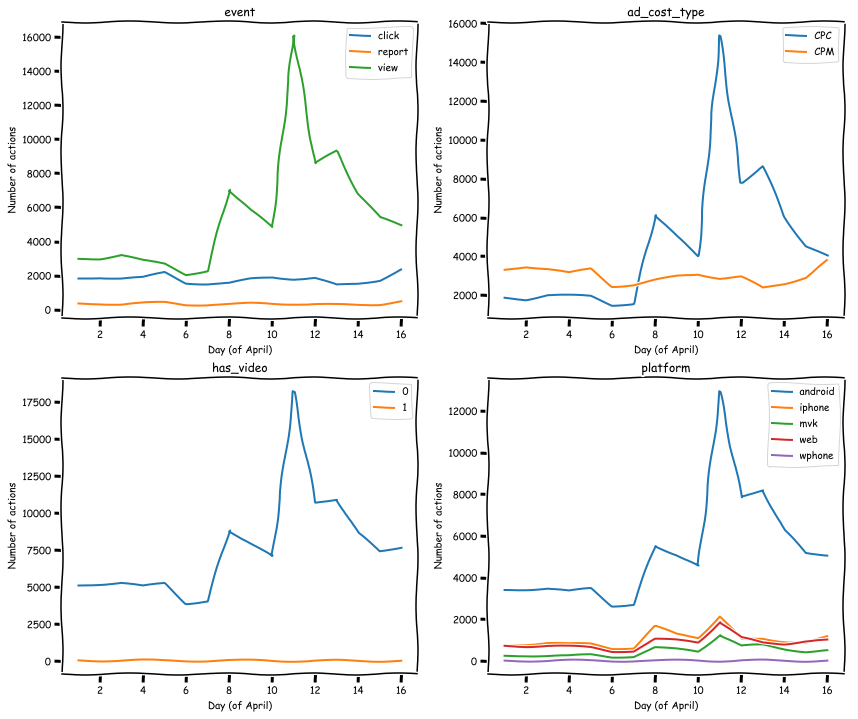

In [9]:
# Features with categorical data
features = ['event', 'ad_cost_type', 'has_video', 'platform']

# Plot features
plot_features(features)

## Analysis

From the graphics above we can see that something went wrong with ***views*** of ***CPC*** advertisements.

Let's get the most popular ad on 11th of April (day when anomaly happened).

In [10]:
data[data['date'] == 11].groupby('ad_id').size().sort_values(ascending=False)[:5]

ad_id
ad_49554    9640
ad_49556    3455
ad_49560     512
ad_49564     334
ad_388       101
dtype: int64

So we see, that ***ad_49554*** has 3x and 19x more actions than second and third most popular ads, respectively. Let's analyse these top-5 ads.

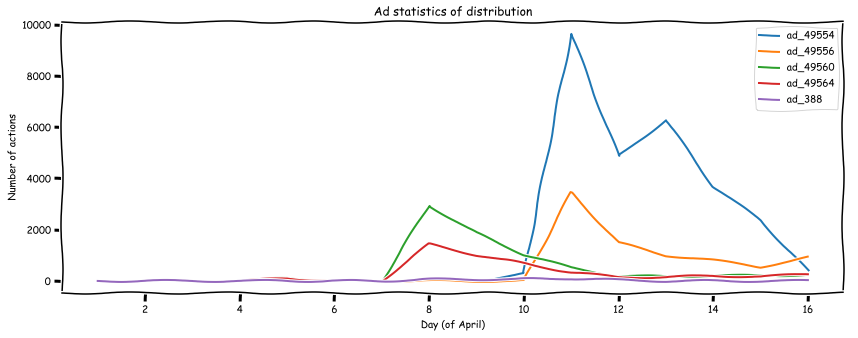

In [11]:
spike_ads = data[data['date'] == 11].groupby(
    'ad_id').size().sort_values(ascending=False).index[:5]
plot_ad_popularity(spike_ads)

## Notification

One of the possible methods to detect such spikes is to track a moving average of number of views and alert in cases when view count for a window is N standard deviations away from the mean.

In the example below we will calculate [Z-Score](https://en.wikipedia.org/wiki/Standard_score) for different moving windows and alert when score is too high or low.

In [12]:
# Make a new DataFrame with number of views per minute
views = pd.DataFrame(data.groupby('time').size(), columns=['views'])

# Running mean with different windows
views['mean_5m'] = views['views'].rolling('300s').mean() # 5 minutes
views['mean_1h'] = views['views'].rolling('3600s').mean() # 1 hour
views['mean_1d'] = views['views'].rolling('86400s').mean() # 1 day

# Means for different windows
mean_5m = np.mean(views['mean_5m'])
mean_1h = np.mean(views['mean_1h'])
mean_1d = np.mean(views['mean_1d'])

# Standard deviations for different windows
std_5m = np.std(views['mean_5m'])
std_1h = np.std(views['mean_1h'])
std_1d = np.std(views['mean_1d'])

# Calculate z-scores for all windows
views['z_score_5m'] = (views['mean_5m'] - mean_5m) / std_5m # 5 minutes
views['z_score_1h'] = (views['mean_1h'] - mean_1h) / std_1h # 1 hour
views['z_score_1d'] = (views['mean_1d'] - mean_1d) / std_1d # 1 day

In [13]:
views.sample(5)

,views,mean_5m,mean_1h,mean_1d,z_score_5m,z_score_1h,z_score_1d
time,,,,,,,
2019-04-13 07:48:00,8,11.8,9.216667,8.010340,1.367967,0.806510,0.889998
2019-04-14 05:35:00,5,3.0,1.822222,8.234351,-0.673540,-0.987652,0.979264
2019-04-16 14:23:00,6,6.0,6.350000,5.631618,0.022428,0.110952,-0.057900
2019-04-08 10:13:00,2,4.2,3.616667,3.437702,-0.395152,-0.552254,-0.932154
2019-04-10 22:38:00,6,5.8,6.416667,5.411052,-0.023969,0.127128,-0.145793


In [14]:
# Add date column
views['date'] = views.index.strftime('%Y-%m-%d')

# Number of standard deviations which triggers an alert
N = 1.4

# Going through all days and check for a spike
for day in sorted(set(views['date'])):
    day_ratios = views[views['date'] == day]['z_score_1h']
    pred = '!!! ALERT !!!' if any(day_ratios > N) else 'Normal'
    print(f'{day}: {pred}')

2019-04-01: Normal
2019-04-02: Normal
2019-04-03: Normal
2019-04-04: Normal
2019-04-05: Normal
2019-04-06: Normal
2019-04-07: Normal
2019-04-08: !!! ALERT !!!
2019-04-09: Normal
2019-04-10: Normal
2019-04-11: !!! ALERT !!!
2019-04-12: !!! ALERT !!!
2019-04-13: !!! ALERT !!!
2019-04-14: Normal
2019-04-15: Normal
2019-04-16: Normal


## Conclusion

So I can say that this number of actions on April 11 is abnormal. It happend because of the ***ad_49554*** and a little bit because of ***ad_49556***. They have a lot of views on these days but from the last graphic above we see that ***ad_49554*** has spiked only over three days. Maybe this ad has been bought only for these three days. Another possible reason of this spike is that this ad was ***CPC*** paid. It means that the system shows this ad as hard as it can for extra shows in hope of many clicks.